In [1]:
!pip install langdetect
!pip install googletrans==3.1.0a0
!pip install unidecode==1.3.6

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Not uninstalling idna at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'idna'. No files were found to uninstall.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import unidecode

from langdetect import detect
from googletrans import Translator

In [3]:
translator = Translator()

In [4]:
# Loading the dataset
df = pd.read_csv('data/tweet_NLP_Data.csv')

# EDA

In [5]:
# Overall description of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79592 entries, 0 to 79591
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    79496 non-null  object
 1   label   79592 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [6]:
print('Dataset tweets: ',len(df),'\nDataset shape: ',df.shape)

Dataset tweets:  79592 
Dataset shape:  (79592, 2)


In [7]:
# Identifying the target portions
df['label'].value_counts()

HOTD    42094
ROP     37498
Name: label, dtype: int64

In [8]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

([<matplotlib.patches.Wedge at 0x7fdf112fbee0>,
 [Text(-0.1195662960655121, 1.314573657443802, 'HOTD'),
  Text(0.11956629606551136, -1.314573657443802, 'ROP')],
 [Text(-0.0652179796720975, 0.7170401767875283, '52.9%\n(42094)'),
  Text(0.06521797967209711, -0.7170401767875283, '47.1%\n(37498)')])

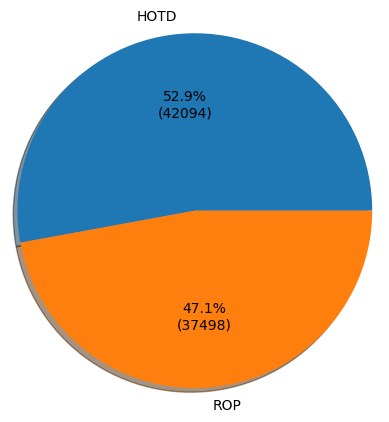

In [9]:
values = [df['label'].value_counts()[0],df['label'].value_counts()[1]]
labels = ['HOTD','ROP']

plt.pie(values,labels=labels,radius=1.2,autopct=autopct_format(values), shadow=True)

HOTD    0.528872
ROP     0.471128
Name: label, dtype: float64


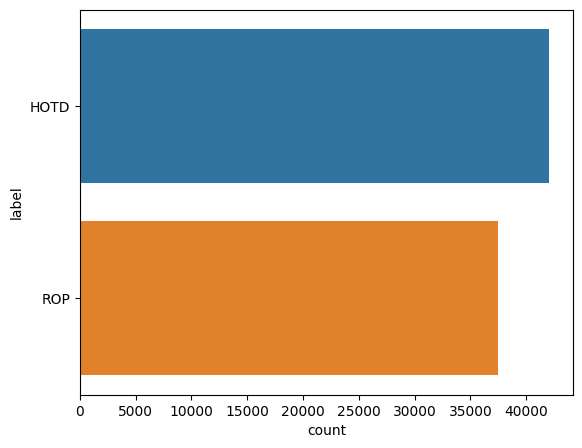

In [10]:
stats_target = df['label'].value_counts(normalize=True)
print(stats_target)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(data=df,y='label')
plt.show()

In [11]:
for idx in range(len(df['text'])):
    try:
        if detect(str(df['text'][idx])) == 'en' or detect(str(df['text'][idx])) == 'es':
           print('YES:',detect(str(df['text'][idx])))
        else:
            df.drop(idx, axis=0, inplace=True)
            #print('adios',idx,detect(str(df['text'][idx])))
    except:
        df.drop(idx, axis=0, inplace=True)
        #print('adios 2.0',idx)

YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: pt
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: es
YES: en
YES: en
YES: en
YES: tl
YES: en
YES: en
YES: en
YES: es
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: es
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: en
YES: es
YES: en
YES: en
YES: en


([<matplotlib.patches.Wedge at 0x7fdf10ed7160>,
 [Text(-0.012662068197277016, 1.3199392683108446, 'HOTD'),
  Text(0.012661944615643359, -1.3199392694963472, 'ROP')],
 [Text(-0.006906582653060191, 0.719966873624097, '50.3%\n(36739)'),
  Text(0.006906515244896377, -0.7199668742707348, '49.7%\n(36293)')])

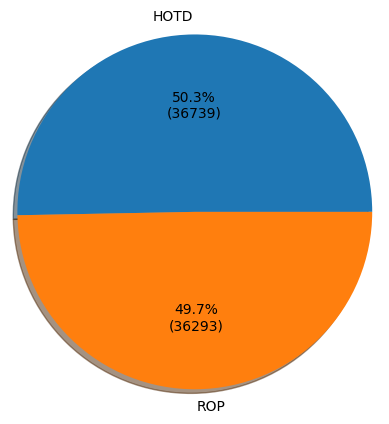

In [12]:
values = [df['label'].value_counts()[0],df['label'].value_counts()[1]]
labels = ['HOTD','ROP']

plt.pie(values,labels=labels,radius=1.2,autopct=autopct_format(values), shadow=True)

In [13]:
# Identifying the target portions
df['label'].value_counts()

ROP     36739
HOTD    36293
Name: label, dtype: int64

ROP     0.503053
HOTD    0.496947
Name: label, dtype: float64


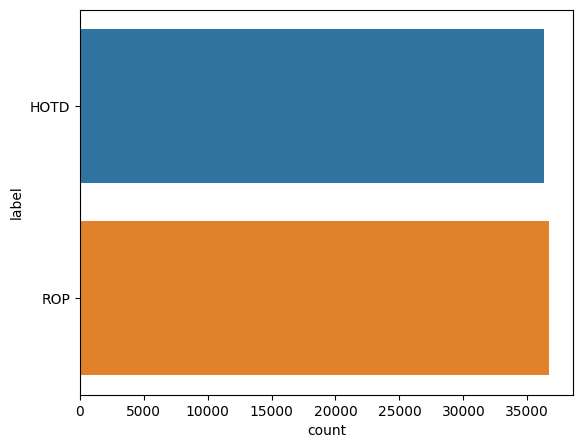

In [14]:
stats_target = df['label'].value_counts(normalize=True)
print(stats_target)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(data=df,y='label')
plt.show()

In [30]:
# Reseting the index
df.reset_index(drop=True,inplace=True)

# Language Detection

In [27]:
for idxa in range(len(df['text'])):

    language = detect(str(df['text'][idxa]))

    if language != 'en':
        translation = translator.translate(df['text'][idxa], src=language)
        df['text'][idxa] = translation.text

In [ ]:
for idxe in range(len(df['text'])):

    language = detect(str(df['text'][idxe]))

    if language != 'en':
        print('Other language')

# Data Preprocessing

## Missing Values

In [ ]:
# Nall values represent the 0.1% of the dataset
df.isna()

,text,label
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
79587,False,False
79588,False,False
79589,False,False
79590,False,False


In [ ]:
#Create a mask for the rows containing atleast one NaN value
mask = df.isna().any(axis=1)

#Pass the mask to df.loc[] to obtain the required rows
index_rows_with_null_values = df.loc[mask].index.tolist()

In [ ]:
# Removing all rows that contains NaN values
df.drop(index_rows_with_null_values,axis=0,inplace=True)

# Reseting the index
df.reset_index(drop=True,inplace=True)

# Verifying we alredy have removed all NaN values from the dataset
df.isna()

,text,label
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
79491,False,False
79492,False,False
79493,False,False
79494,False,False


## Text Cleaning

In [ ]:
global hash_list
hash_list = []

In [ ]:
def getHashtags(text):
  hashtags = re.findall('[#]\w+',text)
  if len(hashtags) != 0:
    hash_list.append(hashtags)
    text = re.sub('[#]\w+','',text)
    
  return text

In [ ]:
def tweetCleaner(tweet):
    """
    Function to clean the tweet texts - Noise Removal, Case Normalization, Punctuation Removal
    """
    
    # GENERAL CLEANING 
    # Emojis and emoticons removal
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        "]+", flags=re.UNICODE)

    tweet = getHashtags(tweet) # Get all hashtags on the text
    tweet = re.sub('^RT','',tweet) # Remove RT: Retweet
    tweet = re.sub('www\S+', '', tweet) # Remove website domain
    tweet = re.sub('http\S+', '', tweet) # Remove links
    tweet = re.sub('@[^\s]+', '', tweet) # Remove @username
    tweet = emoji_pattern.sub('', tweet) # Remove emojis and emoticons

    # EXPANDING CONTRACTIONS
    tweet =  re.sub(r"[dD]on't", "do not", tweet)
    tweet =  re.sub(r"[dD]oesn't", "does not", tweet)
    tweet =  re.sub(r"[dD]idn't", "did not", tweet)

    tweet =  re.sub(r"[iI]'m", "i am", tweet)
    tweet =  re.sub(r"[sS]he's", "she is", tweet)
    tweet =  re.sub(r"[hH]e's", "he is", tweet)
    tweet =  re.sub(r"[wW]e're", "we are", tweet)
    tweet =  re.sub(r"[tT]hey're", "they are", tweet)
    tweet =  re.sub(r"[yY]ou're", "you are", tweet)
    tweet =  re.sub(r"[iI]t's", "it is", tweet)
    
    tweet =  re.sub(r"[iI]'ll", "i will", tweet)
    tweet =  re.sub(r"[sS]he'll", "she will", tweet)
    tweet =  re.sub(r"[hH]e'll", "he will", tweet)
    tweet =  re.sub(r"[wW]e'll", "we will", tweet)
    tweet =  re.sub(r"[tT]hey'll", "they will", tweet)
    tweet =  re.sub(r"[yY]ou'll", "you will", tweet)
    tweet =  re.sub(r"[iI]t'll", "it will", tweet)
    tweet =  re.sub(r"[wW]on't", "will not", tweet)

    tweet =  re.sub(r"[iI]'ve", "i have", tweet)
    tweet =  re.sub(r"[sS]he've", "she have", tweet)
    tweet =  re.sub(r"[hH]e've", "he have", tweet)
    tweet =  re.sub(r"[wW]e've", "we have", tweet)
    tweet =  re.sub(r"[tT]hey've", "they have", tweet)
    tweet =  re.sub(r"[yY]ou've", "you have", tweet)
    tweet =  re.sub(r"[iI]t've", "it have", tweet)

    tweet =  re.sub(r"[iI]'d", "i had", tweet)
    tweet =  re.sub(r"[sS]he'd", "she had", tweet)
    tweet =  re.sub(r"[hH]e'd", "he had", tweet)
    tweet =  re.sub(r"[wW]e'd", "we had", tweet)
    tweet =  re.sub(r"[tT]hey'd", "they had", tweet)
    tweet =  re.sub(r"[yY]ou'd", "you had", tweet)
    tweet =  re.sub(r"[iI]t'd", "it had", tweet)

    tweet =  re.sub(r"[aA]ren't", "are not", tweet)
    tweet =  re.sub(r"[iI]sn't", "is not", tweet)
    tweet =  re.sub(r"[hH]aven't", "have not", tweet)
    tweet =  re.sub(r"[hH]asn't", "has not", tweet)
    tweet =  re.sub(r"[wW]asn't", "was not", tweet)
    tweet =  re.sub(r"[wW]eren't", "were not", tweet)

    tweet =  re.sub(r"[wW]hat's", "what is", tweet)
    tweet =  re.sub(r"[wW]here's", "where is", tweet)
    tweet =  re.sub(r"[wW]ho's", "who is", tweet)
    tweet =  re.sub(r"[wW]hich's", "which is", tweet)
    tweet =  re.sub(r"[hH]ere's", "here is", tweet)

    tweet = re.sub(r"[cC]an't", "cannot", tweet)
    tweet = re.sub(r"[cC]ouldn't", "could not", tweet)
    tweet = re.sub(r"[wW]ouldn't", "would not", tweet)
    tweet = re.sub(r"[sS]houldn't", "should not", tweet)
    tweet = re.sub(r"[wW]ould've", "would have", tweet)
    tweet = re.sub(r"[sS]hould've", "should have", tweet)
    tweet = re.sub(r"[CC]ould've", "Could have", tweet)

    tweet =  re.sub(r"[yy]'all", "you all", tweet)
    tweet =  re.sub(r"[lL]et's", "let us", tweet)
    tweet =  re.sub(r"ain't", "am not", tweet)
    tweet =  re.sub(r"<3", "love", tweet)
    tweet =  re.sub(r"gonna", "going to", tweet)
    tweet =  re.sub(r"wanna", "want to", tweet)
    tweet = re.sub(r"[bB]ffs", "best friends", tweet)
    tweet = re.sub(r"[tT]oday's episode", "the episode of today ", tweet)

    tweet = re.sub('\W+', ' ',tweet) #Remove all the characters that are not letters or numbers
    
    tweet = re.sub('[\s]+', ' ', tweet) #Remove aditional white spaces
    tweet = tweet.lower() # Lower case


    return tweet

In [ ]:
df['text cleaned'] = df['text'].apply(tweetCleaner)

In [ ]:
for idx in range(len(df['text cleaned'])):
    print(idx)
    if df['text cleaned'][idx] == ' ' or df['text cleaned'][idx] == '' or len(df['text cleaned'][idx]) <= 6:

        if df['label'][idx] == 'HOTD':
            df['text cleaned'][idx] = 'House of the dragon season unbelievable'
        else:
            df['text cleaned'][idx] = 'Rings of power dramactically changed'

    try:    
        filter1 = detect(df['text cleaned'][idx])
    except:
        df['text cleaned'][idx] = unidecode.unidecode(df['text cleaned'][idx], 'utf-8') # Converting to UTF-8
        filter1 = detect(df['text cleaned'][idx])

    if filter1 != 'en':     
        translation = translator.translate(df['text cleaned'][idx], src=filter1)
        df['text cleaned'][idx] = translation.text

78497
78498
78499
78500
78501
78502
78503
78504
78505
78506
78507
78508
78509
78510
78511
78512
78513
78514
78515
78516
78517
78518
78519
78520
78521
78522
78523
78524
78525
78526
78527
78528
78529
78530
78531
78532
78533
78534
78535
78536
78537
78538
78539
78540
78541
78542
78543
78544
78545
78546
78547
78548
78549
78550
78551
78552
78553
78554
78555
78556
78557
78558
78559
78560
78561
78562
78563
78564
78565
78566
78567
78568
78569
78570
78571
78572
78573
78574
78575
78576
78577
78578
78579
78580
78581
78582
78583
78584
78585
78586
78587
78588
78589
78590
78591
78592
78593
78594
78595
78596
78597
78598
78599
78600
78601
78602
78603
78604
78605
78606
78607
78608
78609
78610
78611
78612
78613
78614
78615
78616
78617
78618
78619
78620
78621
78622
78623
78624
78625
78626
78627
78628
78629
78630
78631
78632
78633
78634
78635
78636
78637
78638
78639
78640
78641
78642
78643
78644
78645
78646
78647
78648
78649
78650
78651
78652
78653
78654
78655
78656
78657
78658
78659
78660
78661
78662
7866

In [ ]:
df['text cleaned'] = df['text cleaned'].apply(tweetCleaner)

In [ ]:
df.to_csv('data/tweet_nlp_data_cleaned.csv',index = False)

In [ ]:
df = pd.read_csv('data/tweet_nlp_data_cleaned.csv')
df.head(5)

,text,label,text cleaned
0,@BookstAnna Uncover the truth.\nStream #HOTD t...,HOTD,uncover the truth stream tonight at 9pm on re...
1,RT @arishatistic: the kiss we deserved\n\n#hot...,HOTD,the kiss we deserved
2,@LOTRonPrime please make an strategy game like...,ROP,please make an strategy game like age of empi...
3,RT @caffrey05: Ya quiero que se muera Viserys ...,HOTD,i already want viserys to die so that the real...
4,This is a great watch and follow for those who...,ROP,this is a great watch and follow for those who...


In [ ]:
df['text cleaned'][2588]

'house of the dragon season unbelievable'

## Normalization Techniques

https://inside-machinelearning.com/en/eda-nlp/

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=00a22f29-a5e3-4429-9c65-3f412ce34eac' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>